In [155]:
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape

import tensorflow_datasets as tfds

In [156]:
# Thor DataLoad
# Specify the path to the manually downloaded dataset
data_dir = r'C:\Users\thorp\OneDrive\Dokumenter\Uni\Kandidat\Anvendt maskinlæring\Exam\Data\patch_camelyon'

# Load PatchCamelyon dataset using TFDS
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label # Here i make sure that labels are not passed through since the AE does not use labels

In [157]:
ds1,ds2,ds3 = tfds.load('patch_camelyon',split=['train[:20%]','test[:5%]','validation[:5%]'],
                        data_dir = data_dir,
                        download=False,
                        shuffle_files=True)

In [158]:
train_dataset       = ds1.map(convert_sample).batch(32)
validation_dataset  = ds3.map(convert_sample).batch(32)
test_dataset        = ds2.map(convert_sample).batch(32)

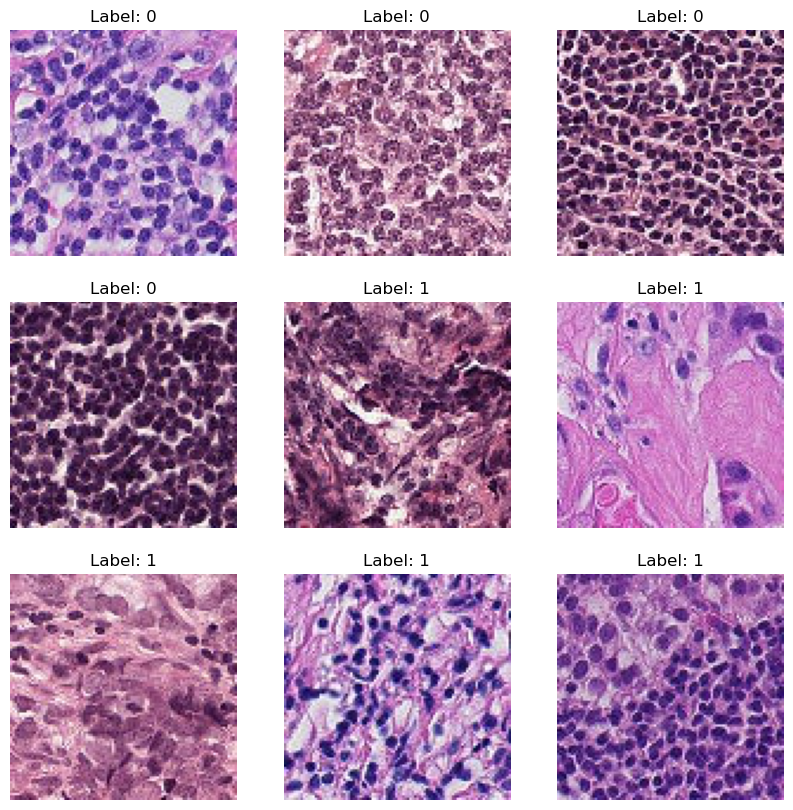

In [159]:
# Take 9 samples from the training set for visualization
samples = list(ds1.take(9))

# Display a 3x3 grid of images
plt.figure(figsize=(10, 10))
for i, sample in enumerate(samples):
    image, label = sample['image'], sample['label']
    image_array = image.numpy()

    plt.subplot(3, 3, i + 1)
    plt.imshow(image_array)
    plt.title(f"Label: {label.numpy()}")
    plt.axis("off")

plt.show()
#This is basically just to head the data to test if it represented as expected

**Problem 1:** 

During the semester you have become very excited about working on the PatchCamelyon (PCam) 
data. Like Veeling et al (2018), you are primarily interested in developing machine learning models that, based on patches of whole-slide images of lymph node sections, can assist pathologists in 
tumor detection.  

The primary objective of this exam is to perform image classification on the PCam dataset, with a 
focus on using autoencoders for image compression.  As a reminder, the PCAM dataset consists of 327,680 color images (96x96pxs) extracted from 
histopathologic scans of lymph node sections. Each image is annotated with a binary label 
indicating presence of metastatic tissue. Specifically, the dataset is divided into 262,144 training 
images, 32,768 validation images, and 32,768 test images. You must use the training/validation 
images to train/validate models that perform well at classifying the test images. Importantly, you are not required to use the full dataset. Use the amount of data that is feasible for you and your hardware configuration.

The PCam dataset is available from many online sources but 
some of them are very slow. Therefore, I recommend accessing the dataset from my SDU 
repository: Link to PCAM. Further instructions and hints on how to load the data efficiently and flexibly by using the module tfds|Tensorflow Dataset are available on the course site’s itslearning platform.

Questions:

You wish to perform image classification. However, you are a little concerned about the size of the 
PCAM images. Their size might be too demanding for your hardware configuration, potentially 
hindering proper hyperparameter tuning and downstream model evaluation. Hence, you wish as a 
pre-processing step to compress the images by using autoencoders (both AEs and VAEs).

1. Discuss how you can use autoencoders to compress images. Motivate why you think 
compressing the images by using AE/VAE will work here and will be better than just simple 
resizing for example by using the function:  

**Initial AE**

In [131]:
# Define the encoder model, simple model with alternating conv and pooling importantly the input shape is set to 96*96*3 due to the shape of the 96*96 RGB images
encoder = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(96, 96, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
])

# Define the decoder model, here i don't need to specify the input shape since it will use the output of the encoder
decoder = tf.keras.Sequential([
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])

# Combine the encoder and decoder to form the autoencoder, standard application
autoencoder = tf.keras.Sequential([
    encoder,
    decoder
])
autoencoder.summary()
# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')  # Using Mean Squared Error as the loss for reconstruction, this is normal for reconstruction

# Train the autoencoder, only 1 epoch since it is just to test 
# autoencoder.fit(train_dataset, epochs=1, validation_data=validation_dataset)

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_29 (Sequential)  (None, 24, 24, 128)       93248     
                                                                 
 sequential_30 (Sequential)  (None, 96, 96, 3)         93123     
                                                                 
Total params: 186,371
Trainable params: 186,371
Non-trainable params: 0
_________________________________________________________________


In [132]:
autoencoded_images = autoencoder.fit(train_dataset)

ValueError: in user code:

    File "c:\Users\thorp\.conda\envs\amfall23Copy\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\thorp\.conda\envs\amfall23Copy\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\thorp\.conda\envs\amfall23Copy\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\thorp\.conda\envs\amfall23Copy\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\thorp\.conda\envs\amfall23Copy\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\thorp\.conda\envs\amfall23Copy\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\thorp\.conda\envs\amfall23Copy\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\thorp\.conda\envs\amfall23Copy\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\thorp\.conda\envs\amfall23Copy\lib\site-packages\keras\losses.py", line 1486, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 3 and 2 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential_31/sequential_30/conv2d_67/Sigmoid, IteratorGetNext:1)' with input shapes: [?,96,96,3], [?,2].


In [69]:
autoencoded_images2 = autoencoder.predict(test_dataset)

52/52 [==============================] - 10s 179ms/step


In [106]:
def display_original_reconstructed(original_images, reconstructed_images):
    n = 5
    plt.figure(figsize=(10, 5))

    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i + 1)
        plt.title("Original")
        plt.imshow(tf.squeeze(original_images[i]['image']))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        bx = plt.subplot(3, n, i + 2 * n + 1)
        plt.title("Reconstructed")
        plt.imshow(tf.squeeze(reconstructed_images[i]))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)

    plt.show()

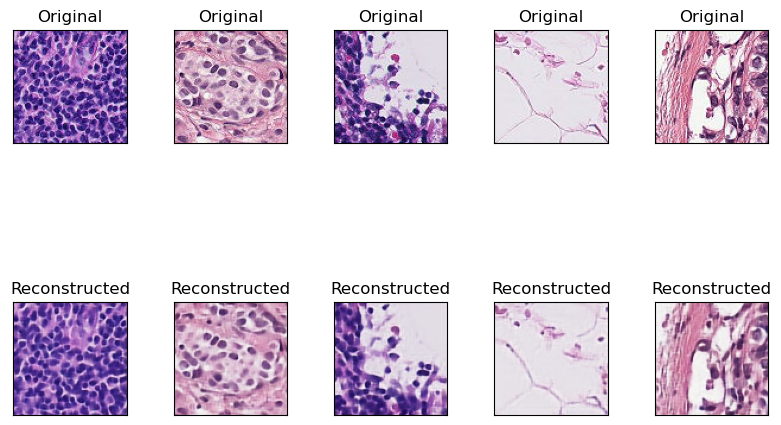

In [107]:
display_original_reconstructed(list(ds2), autoencoded_images2)

**AE for anomaly detection**

In [61]:
aencoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, input_shape=(2,), activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')], name='encoder')
adecoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, input_shape=(1,), activation='relu'),
    tf.keras.layers.Dense(2)], name='decoder')
aautoencoder = tf.keras.models.Sequential([encoder, decoder], name='autoencoder')
aautoencoder.compile(loss='mse', optimizer='adam')
# autoencoder.summary()

autoencoder.fit(train_dataset,validation_data=validation_dataset, epochs=1, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss')])

 898/1639 [===============>..............] - ETA: 16:31 - loss: 0.0067

KeyboardInterrupt: 

**Sample Variational Autoencoder**

In [38]:
latent_dim = 2
# Define the encoder model
vencoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(96, 96, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(96, 96, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2* latent_dim)
])

# Define the decoder model
vdecoder = tf.keras.Sequential([
    tf.keras.layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same'),
])
vdecoder.summary()
# I cannot get the right shape to pass into the VAE

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [28]:
vencoder.output

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'dense_10')>

In [29]:
vencoder.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 24, 24, 128)       73856     
                                                                 
 flatten_5 (Flatten)         (None, 73728)           

In [30]:
vdecoder.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

The next 4 bloacks are the VAE setup, problems with shape (unresolved) specifically the output of the decoder is not 96x96

In [45]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    vals = -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi)
    return tf.reduce_sum(vals, axis=raxis)

def compute_loss(model, x):
    # Output from encoder
    mean, logvar = model.encode(x)    
    # The reparameterization trick
    z = model.reparameterize(mean, logvar)    
    # We assume that p(x|z) is multivariate Bernoulli, ie. the final dense layer 
    # has a sigmoid activation function, see page. 11
    # in Kingma, D. P., & Welling, M. (2013).
    x_logit = model.decode(z)
     # Resize logits to match the shape of labels
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, 
                                                        labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])    
    # Assume normaility of p(z)
    logpz = log_normal_pdf(z, 0., 0.)    
    # Assume normality of q(z|x)
    logqz_x = log_normal_pdf(z, mean, logvar)
    # -tf.reduce_mean(decoder + sampler - encoder)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [51]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, vencoder, vdecoder):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = vencoder
        self.decoder = vdecoder
    
    def encode(self, x):
        params = self.encoder(x)
        return tf.split(params, num_or_size_splits=2, axis=1) # mean, logvar
        
    def decode(self, z):
        return self.decoder(z)
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean #sigma= sqrt(exp(logvar))
    
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return tf.sigmoid(self.decode(eps))

In [52]:
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [53]:
latent_dim = 2
model = VAE(latent_dim, encoder, decoder)
optimizer = tf.keras.optimizers.Adam(1e-4)
test_sample = next(iter(test_dataset.take(1)))[:16]

def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('./vae-img/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [54]:
def train_step(model, train_data, optimizer):
    x, _ = train_data  # Assuming train_data is a tuple (input_data, target_data)
    
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss
# Example usage in your training loop
for epoch in range(1):
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_dataset))
    variational_lower_bound = -loss.result()

    print(f'Epoch: {epoch}, Test set variational lower bound: {10}')

    generate_and_save_images(model, epoch, test_sample)

ValueError: `logits` and `labels` must have the same shape, received ((32, 48, 96, 3) vs (32, 96, 96, 3)).

**CNN**

In [150]:
# Here i make a new converter as to get the labels that will be needed for the CNN
def convert_sample2(sample):
    image, label = sample['image'], sample['label']  # Use the keys in the dataset to specify what we want
    image = tf.image.convert_image_dtype(image, tf.float32) # makes the data type 32 bit float
    label = tf.one_hot(label, 2, dtype=tf.float32) # Combines labels and images
    return image, label

In [151]:
# use the new converter to the train, test and validation set
train_dataset2       = ds1.map(convert_sample2).batch(32)
validation_dataset2  = ds3.map(convert_sample2).batch(32)
test_dataset2        = ds2.map(convert_sample2).batch(32)

Initial CNN

In [135]:
def first_ccn_model():
    input_img = Input(shape=(96,96,3))
    
    x = Conv2D(16, (3, 3), padding='valid', activation='relu')(input_img)
    x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    y = Dense(2, activation='softmax')(x)

    model = Model(inputs=input_img, outputs=y)
    return model

sgd_opt = SGD(learning_rate=0.01, momentum=0.9, decay=0.0, nesterov=True)

model = first_ccn_model()

model.compile(optimizer=sgd_opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(train_dataset2,
                 validation_data=validation_dataset2,
                 epochs=100,  # Increase the number of epochs or set it based on your requirements
                 callbacks=[callback])

NameError: name 'callback' is not defined

2nd CNN (clean)

In [173]:
def second_cnn_model(): # Function to build the second cnn, it is a fucntion because it is easier to deal with.
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
                            input_shape=(96, 96, 3)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.Flatten(), # flatten before fully connected part
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax'),
        ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [174]:
model2 = second_cnn_model()
model2.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_91 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_92 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_93 (Conv2D)          (None, 20, 20, 64)        36928     
                                                                 
 flatten_16 (Flatten)        (None, 25600)           

In [175]:
def model_fit(model,epochs, train, validation):
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
    epochs  = epochs
    hist = model.fit(train,
                    validation_data=validation,
                    epochs=epochs,  # Increase the number of epochs or set it based on your requirements
                    callbacks=[callback] # This specifies the use of EarlyStopping (recognizing when further epoch yield no better result)
                    )
    return hist

In [172]:
base_hist = model_fit(model = model2, epochs = 10,train = train_dataset2, validation = validation_dataset2)

Epoch 1/10
1639/1639 [==============================] - 324s 197ms/step - loss: 0.4789 - accuracy: 0.7765 - val_loss: 0.4325 - val_accuracy: 0.8016
Epoch 2/10
1639/1639 [==============================] - 339s 207ms/step - loss: 0.4094 - accuracy: 0.8174 - val_loss: 0.4295 - val_accuracy: 0.7973
Epoch 3/10
1639/1639 [==============================] - 331s 202ms/step - loss: 0.3499 - accuracy: 0.8499 - val_loss: 0.4576 - val_accuracy: 0.7998
Epoch 4/10
1639/1639 [==============================] - 324s 198ms/step - loss: 0.2862 - accuracy: 0.8821 - val_loss: 0.4298 - val_accuracy: 0.8260
Epoch 5/10
1639/1639 [==============================] - 322s 196ms/step - loss: 0.2187 - accuracy: 0.9135 - val_loss: 0.4427 - val_accuracy: 0.8211
Epoch 6/10
1639/1639 [==============================] - 320s 195ms/step - loss: 0.1552 - accuracy: 0.9401 - val_loss: 0.5796 - val_accuracy: 0.8150
Epoch 7/10
1639/1639 [==============================] - 320s 195ms/step - loss: 0.1114 - accuracy: 0.9586 - val_

The 1 epoch run has high validation loss and high 70% accuracy, without validation both are quite low.

Is this a case of overfitting?

3rd CNN (now i add normalization and spatial dropout)

In [176]:
def third_cnn_model(): # Function to build the second cnn, it is a fucntion because it is easier to deal with.
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
                            input_shape=(96, 96, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.SpatialDropout2D(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, activation='softmax'),
        ])
    sgd_opt = SGD(learning_rate=0.01, momentum=0.9, decay=0.0, nesterov=True)
    model.compile(optimizer=sgd_opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
def third_cnn_model(): # Function to build the second cnn, it is a fucntion because it is easier to deal with.
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
                            input_shape=(96, 96, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.SpatialDropout2D(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, activation='softmax'),
        ])
    sgd_opt = SGD(learning_rate=0.01, momentum=0.9, decay=0.0, nesterov=True)
    model.compile(optimizer=sgd_opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [177]:
model3 = third_cnn_model()
model3.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 94, 94, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_95 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_5 (Batc  (None, 29, 29, 64)       256       
 hNormalization)                                                 
                                                     

In [178]:
hist3 = model_fit(model3,100,test_dataset2,validation_dataset2)

Epoch 1/100
52/52 [==============================] - 12s 213ms/step - loss: 0.5790 - accuracy: 0.7473 - val_loss: 1.2900 - val_accuracy: 0.4774
Epoch 2/100
52/52 [==============================] - 10s 198ms/step - loss: 0.4251 - accuracy: 0.8028 - val_loss: 0.8741 - val_accuracy: 0.6551
Epoch 3/100
52/52 [==============================] - 11s 216ms/step - loss: 0.3935 - accuracy: 0.8339 - val_loss: 1.0669 - val_accuracy: 0.6392
Epoch 4/100
52/52 [==============================] - 12s 231ms/step - loss: 0.3496 - accuracy: 0.8468 - val_loss: 1.0410 - val_accuracy: 0.6593
Epoch 5/100
52/52 [==============================] - 12s 235ms/step - loss: 0.3070 - accuracy: 0.8700 - val_loss: 0.8952 - val_accuracy: 0.6484
Epoch 6/100
52/52 [==============================] - 13s 253ms/step - loss: 0.2202 - accuracy: 0.9115 - val_loss: 0.9642 - val_accuracy: 0.6667
Epoch 7/100
52/52 [==============================] - 13s 243ms/step - loss: 0.1718 - accuracy: 0.9341 - val_loss: 0.9884 - val_accuracy:

In [231]:
best_epoch = hist3.history['val_accuracy'].index(max(hist3.history['val_accuracy'])) + 1
print(best_epoch) # note find a way to extract the best epoch with values

13


Validation accuracy went up to 76% however the validation loss is  0.99
This is better than the base model however we need to incled the AE

4th CNN now the autoencoder is being incorporated (does not work yet)

Update: Does work i dont know why look up categorical crossentropy

In [8]:
print(encoder.input)
print(decoder.output)

NameError: name 'encoder' is not defined

In [18]:
# Combine the encoder, decoder, and CNN to form the full model
combined_input = encoder.input
encoder_output = encoder.output
decoded_output = decoder(encoder_output)
final_output = model3(decoded_output)

full_model = tf.keras.Model(inputs=combined_input, outputs=final_output)
full_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6_input (InputLayer)  [(None, 96, 96, 3)]      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 128)       73856 

In [19]:
# Compile and train the full model - takes a long time due to autoencoder
full_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
full_model.fit(train_dataset2, epochs=1, validation_data=validation_dataset2)

1284/1639 [======================>.......] - ETA: 9:34 - loss: 0.4787 - accuracy: 0.7766

KeyboardInterrupt: 